# Analysis of Luxury Car Market

## Data Scraping
Data were scraped from: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

In [ ]:
# import sys, re, time, string, random, csv, argparse
# import requests
# import numpy as n
# import pandas as pd
# import matplotlib.pyplot as plt

# from scipy.special import psi

# # web scraping libraries
# from bs4 import BeautifulSoup

# from tqdm.notebook import tqdm

# # NLP libraries
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# from nltk.tokenize import wordpunct_tokenize

# print('\n¡Libraries have been imported succesffully!')

# # Scraping code
# car_comments = pd.DataFrame()
# ncom = 0 # number of posts
# page = 0 # number page
# while ncom < 5000:
#   page += 1
#   # Url of the Entry Level Luxury forum 
#   url_forum = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{page}'
#   # Downloading source code of the url
#   html_data = requests.get(url_forum).text
#   soup = BeautifulSoup(html_data, 'html.parser')
#   # Saving date and message
#   author_soup = [i.text.replace('\n','').rstrip() for i in soup.find_all('span', class_ = 'Author')]
#   date_soup = [i['datetime'][:10] for i in soup.find_all('time')]
#   message_soup = [i.text.replace('\n','') for i in soup.find_all('div', class_ = 'Message userContent')]
#   # Creating a DataFrame
#   comments = pd.DataFrame({'user':author_soup,'date':date_soup,'text':message_soup})
#   car_comments = car_comments.append(comments)
#   ncom = len(car_comments)
#   print('Dowloading {} comments from Edmunds.com'.format(ncom))

# # Formatting data
# car_comments['date'] = pd.to_datetime(car_comments['date']).dt.strftime('%m/%-d/%Y')
# car_comments.reset_index(inplace=True, drop=True)

# # Saving data
# car_comments.to_csv('scrapped_data.csv', header=False, index=False)

#### Loading Data

In [1]:
import pandas as pd
df = pd.read_csv('scrapped_data.csv', names = ['user','date','text'])
df.head()

,user,date,text
0,cybersol,23-Mar,Entry level performance luxury sedans are a ho...
1,merc1,25-Mar,I personally think that with a few tweaks the ...
2,fredvh,25-Mar,I am debating a new purchase and these two are...
3,blueguydotcom,25-Mar,"Great handling, RWD, excellent engine and the ..."
4,hungrywhale,25-Mar,And no manual tranny. That may not matter to y...


## Task A: Test if the data support Zipf’s law econometrically. Also plot the most common 100 words in the data against the theoretical prediction of the law

In [2]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

[nltk_data] Downloading package punkt to /Users/kenzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+') #removes punctuation, keeps only words
def counts(x): #count frequencies
  return Counter(tokenizer.tokenize((x.lower())))
c = df['text'].astype(str).apply(counts)
c

0       {'entry': 3, 'level': 3, 'performance': 4, 'lu...
1       {'i': 11, 'personally': 1, 'think': 1, 'that':...
2       {'i': 6, 'am': 3, 'debating': 1, 'a': 3, 'new'...
3       {'great': 1, 'handling': 1, 'rwd': 1, 'excelle...
4       {'and': 2, 'no': 1, 'manual': 1, 'tranny': 1, ...
                              ...                        
4996    {'i': 2, 'agree': 1, 'with': 2, 'blueguydotcom...
4997    {'don': 1, 't': 1, 'have': 1, 'any': 1, 'inter...
4998    {'don': 1, 't': 2, 'have': 1, 'any': 2, 'inter...
4999    {'amg': 1, 'i': 2, 'have': 1, 'no': 1, 'use': ...
5000    {'alpina': 7, 'is': 7, 'like': 1, 'dinan': 3, ...
Name: text, Length: 5001, dtype: object

In [4]:
all = c.sum()

#### Plotting 100 common words: Hockey Stick

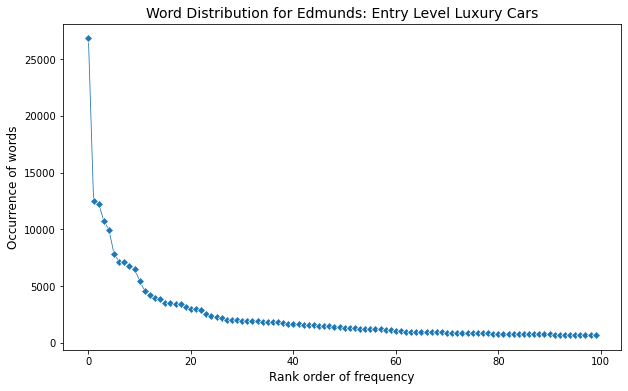

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
x = [i for i in range(100)]
plt.figure(figsize=(10,6))
sns.lineplot(x=x,y=sorted(all.values(),reverse=True)[:100],marker='D', linewidth=.8)
plt.title('Word Distribution for Edmunds: Entry Level Luxury Cars', fontsize=14)
plt.ylabel('Occurrence of words', fontsize=12)
plt.xlabel('Rank order of frequency', fontsize=12)
plt.show()

#### Plotting Frequency Vs Rank on a log scale

<Figure size 432x288 with 0 Axes>

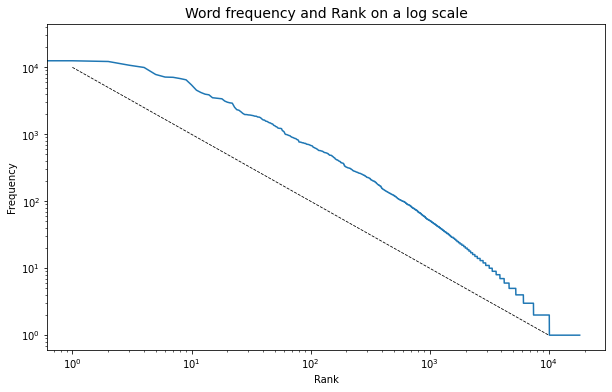

In [6]:
plt.figure()
zipf = sorted(all.values(),reverse=True)
plt.figure(figsize=(10,6))
sns.lineplot(x=[i for i in range(len(zipf))],y=zipf)
plt.title('Word frequency and Rank on a log scale', fontsize=14)
plt.ylabel('Frequency')
plt.xlabel('Rank')
plt.yscale('log')
plt.xscale('log')
plt.plot([1, 10000], [10000, 1], '--', lw=.8, color='black')
plt.show()

#### Empirical Testing of Zipf's Law
To Test if the data support Zipf’s law econometrically:

$ ln\,r = \theta\,ln\left({\dfrac{x_{(r)}}{nx_{(r)}}}\right) + ϵ $<br><br>
$ \text{where :   } r = 1,2,...,n $ <br>
$ \text{Check if :   } \theta = -1 $

#### Hypothesis Test ($θ=-1$)

In [7]:
import numpy as np
from scipy.stats import t
import statsmodels.api as sm

yzipf = np.array(sorted(all.values(),reverse=True))
xzipf = [i+1 for i in range(len(yzipf))]
n = len(yzipf)
ln_r = np.log(xzipf)
ln_x = np.log(yzipf/(n*yzipf[n-1])).reshape((-1, 1))
# Running model to test Zipf's Law
model = sm.OLS(ln_x, ln_r).fit()

print("\n\033[1mCoefficient Analysis\033[0m")
print('-'*62)
print(model.summary2().tables[1])
print('-'*62)
t_stat = (model.params[0]-(-1))/model.bse
t_table = abs(t.ppf(q=.01,df=len(yzipf)-1))
pvalue = t.sf(abs(t_stat), df=len(yzipf)-1)

print("\n\033[1mEmpirical Testing of Zipf's Law\033[0m")
print('-'*32)
print('Null Hypothesis: \u03B8 = -1, alpha=1%')
print('Then, t-value: {:.2f}, t-table: {:.2f} and p-value(99%): {:.4f}'.format(t_stat[0],t_table,pvalue[0]))
print('Since, t-value < t-table --> {:.2f} < {:.2f}'.format(t_stat[0],t_table))
print('At 99% of confidence, there is no statistical evidence to reject the null hypothesis. \u03B8 = {:.4f} is not different from -1.'.format(model.params[0]))


Coefficient Analysis
--------------------------------------------------------------
       Coef.  Std.Err.           t  P>|t|    [0.025    0.975]
x1 -0.993494  0.000398 -2497.94831    0.0 -0.994273 -0.992714
--------------------------------------------------------------

Empirical Testing of Zipf's Law
--------------------------------
Null Hypothesis: θ = -1, alpha=1%
Then, t-value: 16.36, t-table: 2.33 and p-value(99%): 0.0000
Since, t-value < t-table --> 16.36 < 2.33
At 99% of confidence, there is no statistical evidence to reject the null hypothesis. θ = -0.9935 is not different from -1.


### Plotting:   $\,\,\, ln\left({{x_{(r)}}/{nx_{(r)}}}\right)$ Vs $ln\,r $


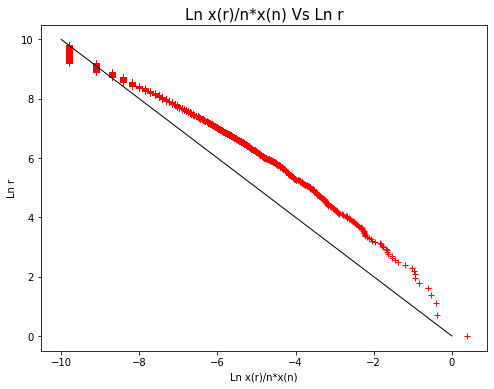

In [8]:
import numpy as np
yzipf = np.array(sorted(all.values(),reverse=True))
xzipf = [i+1 for i in range(len(yzipf))]
n = len(yzipf)
ln_r = np.log(xzipf)
ln_x = np.log(yzipf/(n*yzipf[n-1])).reshape((-1, 1))

# Plot
plt.figure(figsize=(8,6))
plt.plot(ln_x,ln_r,color='r',marker='+',lw=0)
plt.title('Ln x(r)/n*x(n) Vs Ln r', fontsize=15)
plt.ylabel('Ln r')
plt.xlabel('Ln x(r)/n*x(n)')
plt.plot([-10, 0], [10, 0], 'k-', lw=1)
plt.show()

## Task: B Find the top 10 brands from frequency counts. Replace frequently occurring car models with brands

In [9]:
df2 = pd.read_csv('car models and brands.csv').set_index('Model')
map = {
    "hyndai":"hyundai",
    "mercedes-benz":"mercedes",
    "toyata":"toyota",
    "volkwagen":"volkswagen"
}
def removepunc(x):
  s = word_tokenize(x)[0]
  if s in map:
    return map[s]
  return s
df2['Brand'] = df2['Brand'].apply(removepunc)
aspirations = ["want", "love", "dream", "hope", "wish"]
attributes =["performance","luxury","engine","price","handling"]
tempdf = pd.DataFrame({i:'aspirations' for i in aspirations},index=["Brand"]).T
df2=pd.concat([df2,tempdf])
tempdf = pd.DataFrame({i:i for i in attributes},index=["Brand"]).T
df2=pd.concat([df2,tempdf])
cols = sorted(set(df2['Brand']))
import numpy as np
row = np.zeros(len(cols))
def modelcounts(x):
  r = row.copy() #init new row
  for m in df2.index: #iterate over models
    if m in x: #if model in row 
      b = df2["Brand"][m] #get brand of model
      try:
        ind = cols.index(b) #get index of brand
        r[ind] = 1 #mark presence
      except:
        pass
  for i,b in enumerate(cols):
    if b in x:
      r[i]=1
  return r
counts = pd.DataFrame(c.apply(modelcounts).tolist(),columns = cols)
counts

,acura,aspirations,audi,bmw,buick,cadillac,car,chevrolet,chrysler,dodge,...,price,problem,saturn,seat,sedan,subaru,suzuki,toyota,volkswagen,volvo
0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4999,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Appearance of brands per post

In [36]:
# Frequency of car Brands
counts.sum().sort_values(ascending=False)[:5]

car            2563.0
bmw            1356.0
aspirations     855.0
sedan           688.0
performance     683.0
dtype: float64

Top 10 most frequently mentioned brands are 
1. bmw
2. acura
3. audi
4. honda
5. infiniti
6. nissan
7. toyota
8. subaru
9. mercedes
10. volkswagen

## Task C: Calculate lift ratios for associations between the top-10 brands

In [11]:
# Appereance of Top 10 brands
Top_10_brands= counts[["bmw", "acura","audi","honda","infiniti","nissan","toyota","subaru","mercedes","volkswagen"]]
Top_10_brands

,bmw,acura,audi,honda,infiniti,nissan,toyota,subaru,mercedes,volkswagen
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Lifts

In [12]:
# Lift function
#def get_lift(df):
p = 0
df_lf = Top_10_brands

top10_lifts = pd.DataFrame()
N = len(df_lf)
for w1 in df_lf.columns:
  for w2 in df_lf.columns:
    nw1 = df_lf[w1].sum()
    nw2 = df_lf[w2].sum()
    mask1 = (df_lf[w1] == 1)
    mask2 = (df_lf[w2] == 1)
    n12 = len(df_lf[mask1 & mask2])
    lift = (N*n12)/(nw1*nw2)
    top10_lifts.loc[w1,w2] = lift
top10_lifts

,bmw,acura,audi,honda,infiniti,nissan,toyota,subaru,mercedes,volkswagen
bmw,3.688053,1.491869,1.764579,1.271166,1.990088,1.237132,1.343952,1.212036,1.751310,1.674331
acura,1.491869,8.682292,2.086900,2.697220,2.987224,2.225524,1.581943,2.038097,2.231203,1.491437
audi,1.764579,2.086900,11.340136,1.311444,2.442059,1.471347,1.249337,1.756922,3.167636,5.078711
honda,1.271166,2.697220,1.311444,11.340136,1.487691,3.911629,3.940217,1.543962,1.773876,2.295856
infiniti,1.990088,2.987224,2.442059,1.487691,12.378713,2.820466,1.416209,1.685365,2.351264,1.670747
nissan,1.237132,2.225524,1.471347,3.911629,2.820466,15.825949,4.023546,1.634605,1.679849,2.427293
toyota,1.343952,1.581943,1.249337,3.940217,1.416209,4.023546,21.190678,1.392815,2.130906,3.120100
subaru,1.212036,2.038097,1.756922,1.543962,1.685365,1.634605,1.392815,23.478873,1.180502,1.872548
mercedes,1.751310,2.231203,3.167636,1.773876,2.351264,1.679849,2.130906,1.180502,27.938547,4.113651
volkswagen,1.674331,1.491437,5.078711,2.295856,1.670747,2.427293,3.120100,1.872548,4.113651,30.680982


## Task D: Show the brands on a multi-dimensional scaling (MDS) map

In [13]:

dissimilarity_score = 1/top10_lifts
dissimilarity_score

,bmw,acura,audi,honda,infiniti,nissan,toyota,subaru,mercedes,volkswagen
bmw,0.271146,0.670300,0.566708,0.786680,0.502490,0.808321,0.744074,0.825058,0.571001,0.597254
acura,0.670300,0.115177,0.479180,0.370752,0.334759,0.449332,0.632134,0.490654,0.448189,0.670494
audi,0.566708,0.479180,0.088182,0.762518,0.409491,0.679649,0.800425,0.569177,0.315693,0.196900
honda,0.786680,0.370752,0.762518,0.088182,0.672183,0.255648,0.253793,0.647684,0.563737,0.435567
infiniti,0.502490,0.334759,0.409491,0.672183,0.080784,0.354551,0.706111,0.593343,0.425303,0.598535
nissan,0.808321,0.449332,0.679649,0.255648,0.354551,0.063187,0.248537,0.611769,0.595291,0.411982
toyota,0.744074,0.632134,0.800425,0.253793,0.706111,0.248537,0.047191,0.717971,0.469284,0.320503
subaru,0.825058,0.490654,0.569177,0.647684,0.593343,0.611769,0.717971,0.042591,0.847097,0.534032
mercedes,0.571001,0.448189,0.315693,0.563737,0.425303,0.595291,0.469284,0.847097,0.035793,0.243093
volkswagen,0.597254,0.670494,0.196900,0.435567,0.598535,0.411982,0.320503,0.534032,0.243093,0.032593


In [14]:
# import libraries
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import sklearn.datasets as dt
import seaborn as sns         
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler 

In [15]:
scaler = StandardScaler()
dissimilarity_score.replace(np.inf, 1, inplace = True)
X_scaled = scaler.fit_transform(dissimilarity_score)

In [16]:
mds = MDS(2,random_state=0)
mds

X_2d = mds.fit_transform(dissimilarity_score)
X_2d

/Users/kenzhang/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


array([[-0.55422889, -0.56834667],
       [ 0.24762096, -0.25803041],
       [-0.67274836, -0.06474396],
       [ 0.54651923,  0.38641233],
       [-0.1238594 , -0.34023694],
       [ 0.57769297,  0.17257684],
       [ 0.391988  ,  0.63243479],
       [ 0.34480264, -0.77183692],
       [-0.47237725,  0.26517997],
       [-0.2854099 ,  0.54659098]])

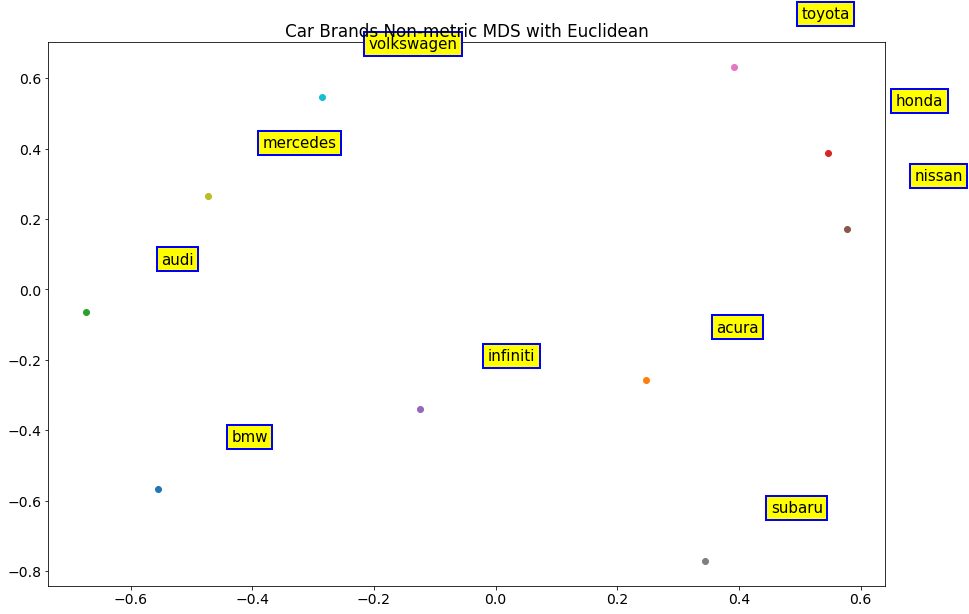

In [17]:
labels = dissimilarity_score.index # get car brand names
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', size=14)
for i in range(len(labels)):
  j = i+1
  coordinates = X_2d[i:j][0]
  x = coordinates[0]
  y = coordinates[1]
  plt.scatter(x,y, label=labels[i]) #c=colors[i]
  t = plt.text(
    x+0.15, y+0.15, labels[i], ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="Square,pad=0.3", fc="yellow", ec="b", lw=2))

title = 'Car Brands Non-metric MDS with Euclidean'

plt.title(title)
plt.show()

####  Insights:


Task C and D generated some intriguing insights. Our initial observations are as as follows:



1.   An assumption we can conclude from the MDS map is that brands on the bottom right side of the graph (fourth quadrant) are more luxury

2. To our surprise, Toyota is far away from other brands in on the map. One would assume that Toyota, one of the most common brand, would be compared(comentioned) against at a high frequence. The graph suggested otherwise.  

3.   Top competitors for each brand:

Bmw: Audi, infiniti
Acura: Infiniti,Honda
Audi: Mercedes,Volkswagen
Honda: Nissan,Toyota
Infiniti: Acura,Audi
Nissan: Honda,Toyota
Toyota: Honda,Nissan
Subaru: Acura,Volkswagen
Mercedes: Audi,Volkswagen
Volkswagen: Audi, Mercedes 




## Task E: Finding most frequently mentioned car features in the discussions. Finding attributes are most strongly associated with each brands? 

In [18]:
p = 0
df_lf = counts

df_lifts = pd.DataFrame()
N = len(df)
for w1 in df_lf.columns:
  for w2 in df_lf.columns:
    nw1 = df_lf[w1].sum()
    nw2 = df_lf[w2].sum()
    mask1 = (df_lf[w1] == 1)
    mask2 = (df_lf[w2] == 1)
    n12 = len(df_lf[mask1 & mask2])
    lift = (N*n12)/(nw1*nw2)
    df_lifts.loc[w1,w2] = lift
df_lifts

,acura,aspirations,audi,bmw,buick,cadillac,car,chevrolet,chrysler,dodge,...,price,problem,saturn,seat,sedan,subaru,suzuki,toyota,volkswagen,volvo
acura,8.682292,1.431817,2.086900,1.491869,4.651228,2.685245,1.283882,1.302344,2.553615,1.913047,...,1.567636,1.377633,1.578598,1.369131,1.817224,2.038097,2.894097,1.581943,1.491437,3.133459
aspirations,1.431817,5.849123,1.313068,1.401892,2.297870,0.904504,1.346462,1.462281,1.548297,1.685340,...,1.678915,1.532427,1.063477,1.732240,1.538795,1.373034,1.299805,1.264005,2.117167,1.451286
audi,2.086900,1.313068,11.340136,1.764579,0.810010,2.922715,1.243300,1.417517,2.167967,1.345440,...,2.178776,1.673821,2.061843,2.093564,1.532896,1.756922,1.260015,1.249337,5.078711,4.092681
bmw,1.491869,1.401892,1.764579,3.688053,1.580594,2.015122,1.246139,1.475221,1.464374,1.750262,...,1.511077,1.279251,2.011665,1.617069,1.399102,1.212036,1.229351,1.343952,1.674331,1.441946
buick,4.651228,2.297870,0.810010,1.580594,178.607143,7.365243,1.393735,13.395536,7.879727,9.081719,...,0.413442,1.977201,32.474026,2.747802,2.596034,3.354125,19.845238,2.270430,2.191499,2.685822
cadillac,2.685245,0.904504,2.922715,2.015122,7.365243,51.556701,1.086251,2.577835,5.307307,5.243054,...,1.551475,1.331723,18.747891,1.388065,1.873427,2.420502,2.864261,1.092303,1.897793,3.488799
car,1.283882,1.346462,1.243300,1.246139,1.393735,1.086251,1.951229,1.317080,1.406033,1.455154,...,1.395671,1.404021,1.419076,1.470926,1.270568,1.163409,1.409221,1.215384,1.472400,1.335051
chevrolet,1.302344,1.462281,1.417517,1.475221,13.395536,2.577835,1.317080,125.025000,7.354412,6.357203,...,0.578819,1.845387,22.731818,1.442596,0.545167,2.934859,13.891667,1.589301,3.068098,3.760150
chrysler,2.553615,1.548297,2.167967,1.464374,7.879727,5.307307,1.406033,7.354412,73.544118,12.465105,...,2.042892,2.713805,6.685829,1.414310,1.817224,2.416943,12.257353,2.804649,3.158336,3.317780
dodge,1.913047,1.685340,1.345440,1.750262,9.081719,5.243054,1.455154,6.357203,12.465105,84.762712,...,0.784840,2.189443,7.705701,2.282073,1.478419,1.989735,4.709040,1.077492,3.640116,0.637314


In [29]:
tokenizer = RegexpTokenizer(r'\w+') 
def appear(x):
    count = Counter(tokenizer.tokenize((x.lower())))
    return Counter({x: 1 for x in count})
c1 = df['text'].astype(str).apply(appear)
x1=c1.sum()

In [21]:
print(x1.most_common()[70])
print(x1.most_common()[111])
print(x1.most_common()[121])
print(x1.most_common()[122])
print(x1.most_common()[132])

('performance', 683)
('luxury', 476)
('engine', 440)
('price', 432)
('handling', 403)


We counted the frequency of all the words(word appear more than once in a comment are considered redundant and only be counted once ), From the top down list, We found that the 5 most frequent attributes 
are: 


1.   Performance: 683
2.   Luxury: 476
3.   engine: 440
4.   price: 432
5.   handling: 403




In [30]:
df_lifts[["performance"]].sort_values(by="performance",ascending=False).head(5)


,performance
performance,7.322108
luxury,3.153429
sedan,2.415870
handling,2.325632
lincoln,2.112147


In [31]:
df_lifts[["luxury"]].sort_values(by="luxury",ascending=False).head(2)

,luxury
luxury,10.506303
kia,3.654366


In [32]:
df_lifts[["engine"]].sort_values(by="engine",ascending=False).head(2)

,engine
engine,11.365909
buick,2.435552


In [33]:
df_lifts[["price"]].sort_values(by="price",ascending=False).head(2)

,price
price,11.576389
suzuki,2.572531


In [34]:
df_lifts[["handling"]].sort_values(by="handling",ascending=False).head(2)

,handling
handling,12.409429
chevrolet,2.481886


## Conclusion and Recommendations:

From the table above, we found that the 5 brands that are most associated with the 5 most ferquent attributes are as following:

*   Performance: lincoln
*   engine: buick
*   luxury: kia
*   price: suzuki
*   handling : chevrolet







*   Assuming that all the sentiments are positive, We can make some recommendations to the customer, if the customer likes the car with better **performance**, then the brand that has the most association with performance is **Lincoln**. More specifically, the brand most associated with the **engine** is **Buick**, and the brand most associated with the **handling** is **Chevrolet**. If the customer is more concerned about the **price**, then the most relevant car brand is **Suzuki**; and for **luxury** cars the brand associated is **Kia**.

* We can observe that **Subaru** is a car brand that possesses both performance and luxury, so it isn't in the top postion but it's well ranked for multiple attributes. Our advice would be invest, buy, or work with any of these 6 brands.

*   In addition to analyzing brands and attributes together, there are actually links between attributes, such as performance and luxury, handling and engine, and luxury and price, we would try to use n-gram to analyze the related words together to get more insights next time.



We developed a list of 5 words associated with aspiration. The phrases were as follows:  
>"want", "love", "dream", "hope", "wish"

We replaced these five words with the word 'aspiration' the same way we replaced the car models with their according brand name. We than get the lift ratio on between the brands and the word 'aspiration'. 

The outputs are as follows:

In [28]:
df_lifts[['aspirations']].sort_values(by='aspirations',ascending=False)[1:11] # aspirational brands

,aspirations
buick,2.297870
mitsubishi,2.288787
mazda,2.120307
volkswagen,2.117167
ford,1.855584
seat,1.732240
dodge,1.685340
infiniti,1.679451
price,1.678915
pontiac,1.637754


We found that the top five car brands with the most words related to aspiration words {want", "love", "dream", "hope" and "wish"} are Buick, Mitsubishi, Mazda, Volkswagen. Buick is the brand tht most positively related to the engine. It also most related to aspiration words, which means that this brand has a very positive image in customers' minds. However,Buick is not in the Top_10_brand, which means that this brand is relatively niche but high quality,and will be a potential stock in the car market in the future.

Buick came out to be the most 'aspired' car brand using our method. This is a very unexpected result as Buick is not a common brand to see in the US. A little further digging found that Buick is normally priced slightly higher than it peer competitors. Buick's closest competitor is Audi according to people's reaction. Perhaps Buick can use this information and market itself as an American luxury alternative by introducing a new product that appeals to the younger crowd. 